# import necessary library

In [319]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_palette(palette='flare')
import statsmodels.api as sm_api
import statsmodels as sm
import yfinance as yf
from datetime import datetime

# download dataset

In [320]:
awal = datetime(year=2018, month=1, day=1)
akhir = datetime(year=2023, month=1, day=1)

In [321]:
stock = yf.download('GOOG', start=awal, end=akhir,)
stock.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-02,52.417000,53.347000,52.261501,53.250000,53.250000,24752000
2018-01-03,53.215500,54.314499,53.160500,54.124001,54.124001,28604000
2018-01-04,54.400002,54.678501,54.200100,54.320000,54.320000,20092000
2018-01-05,54.700001,55.212502,54.599998,55.111500,55.111500,25582000
2018-01-08,55.111500,55.563499,55.081001,55.347000,55.347000,20952000


In [322]:
dataset = pd.DataFrame(stock['Adj Close'])
dataset.head(10)

,Adj Close
Date,
2018-01-02,53.250000
2018-01-03,54.124001
2018-01-04,54.320000
2018-01-05,55.111500
2018-01-08,55.347000
2018-01-09,55.313000
2018-01-10,55.130501
2018-01-11,55.276001
2018-01-12,56.112999


# explarotary data analysis

In [323]:
def adjust(w=5):
    plt.figure(figsize=(16, w), dpi=300)

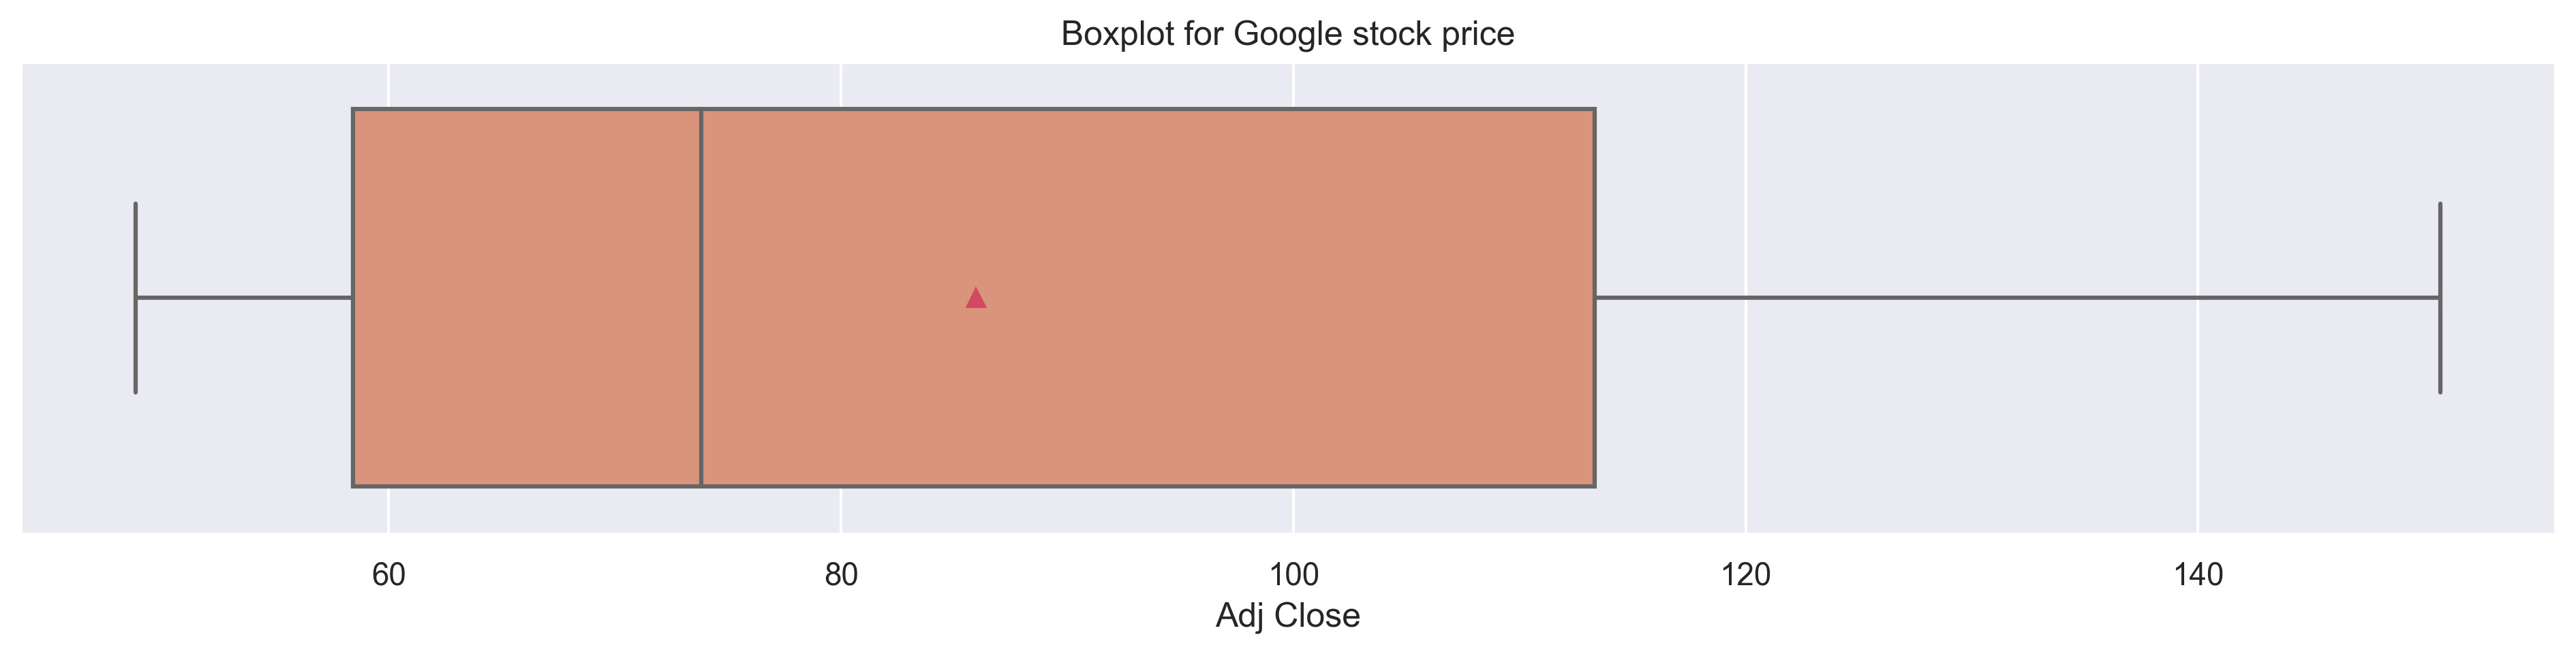

Descriptive Analysis


count    1259.000
mean       85.967
std        31.245
min        48.811
25%        58.422
50%        73.812
75%       113.318
max       150.709
Name: Adj Close, dtype: float64

In [324]:
adjust(w=3)
sns.boxplot(x=dataset['Adj Close'], showmeans=True)
plt.title('Boxplot for Google stock price')
plt.show()
print('Descriptive Analysis')
dataset['Adj Close'].describe().round(3)

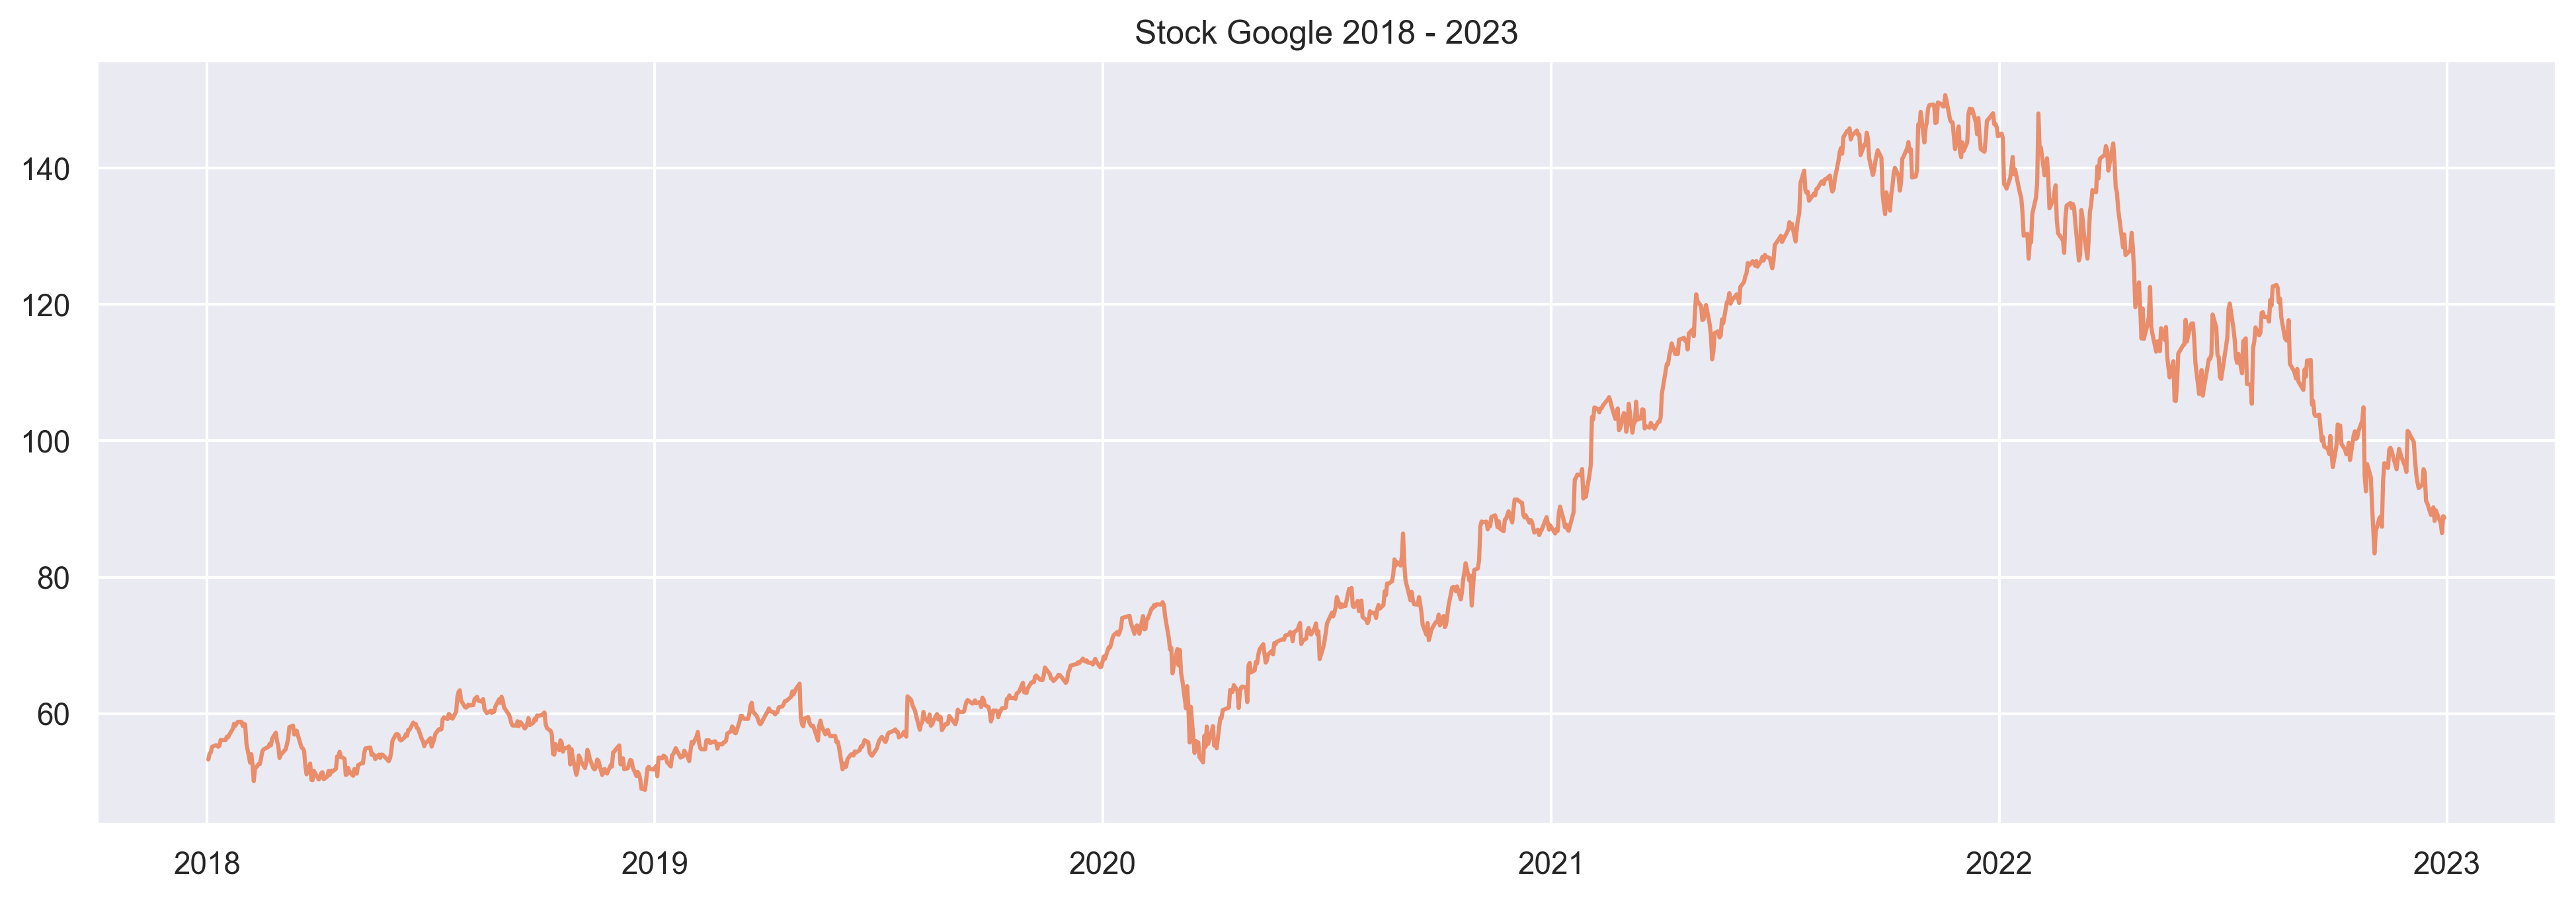

In [325]:
adjust()
plt.plot(dataset.index, dataset['Adj Close'])
plt.title('Stock Google 2018 - 2023')
plt.show()

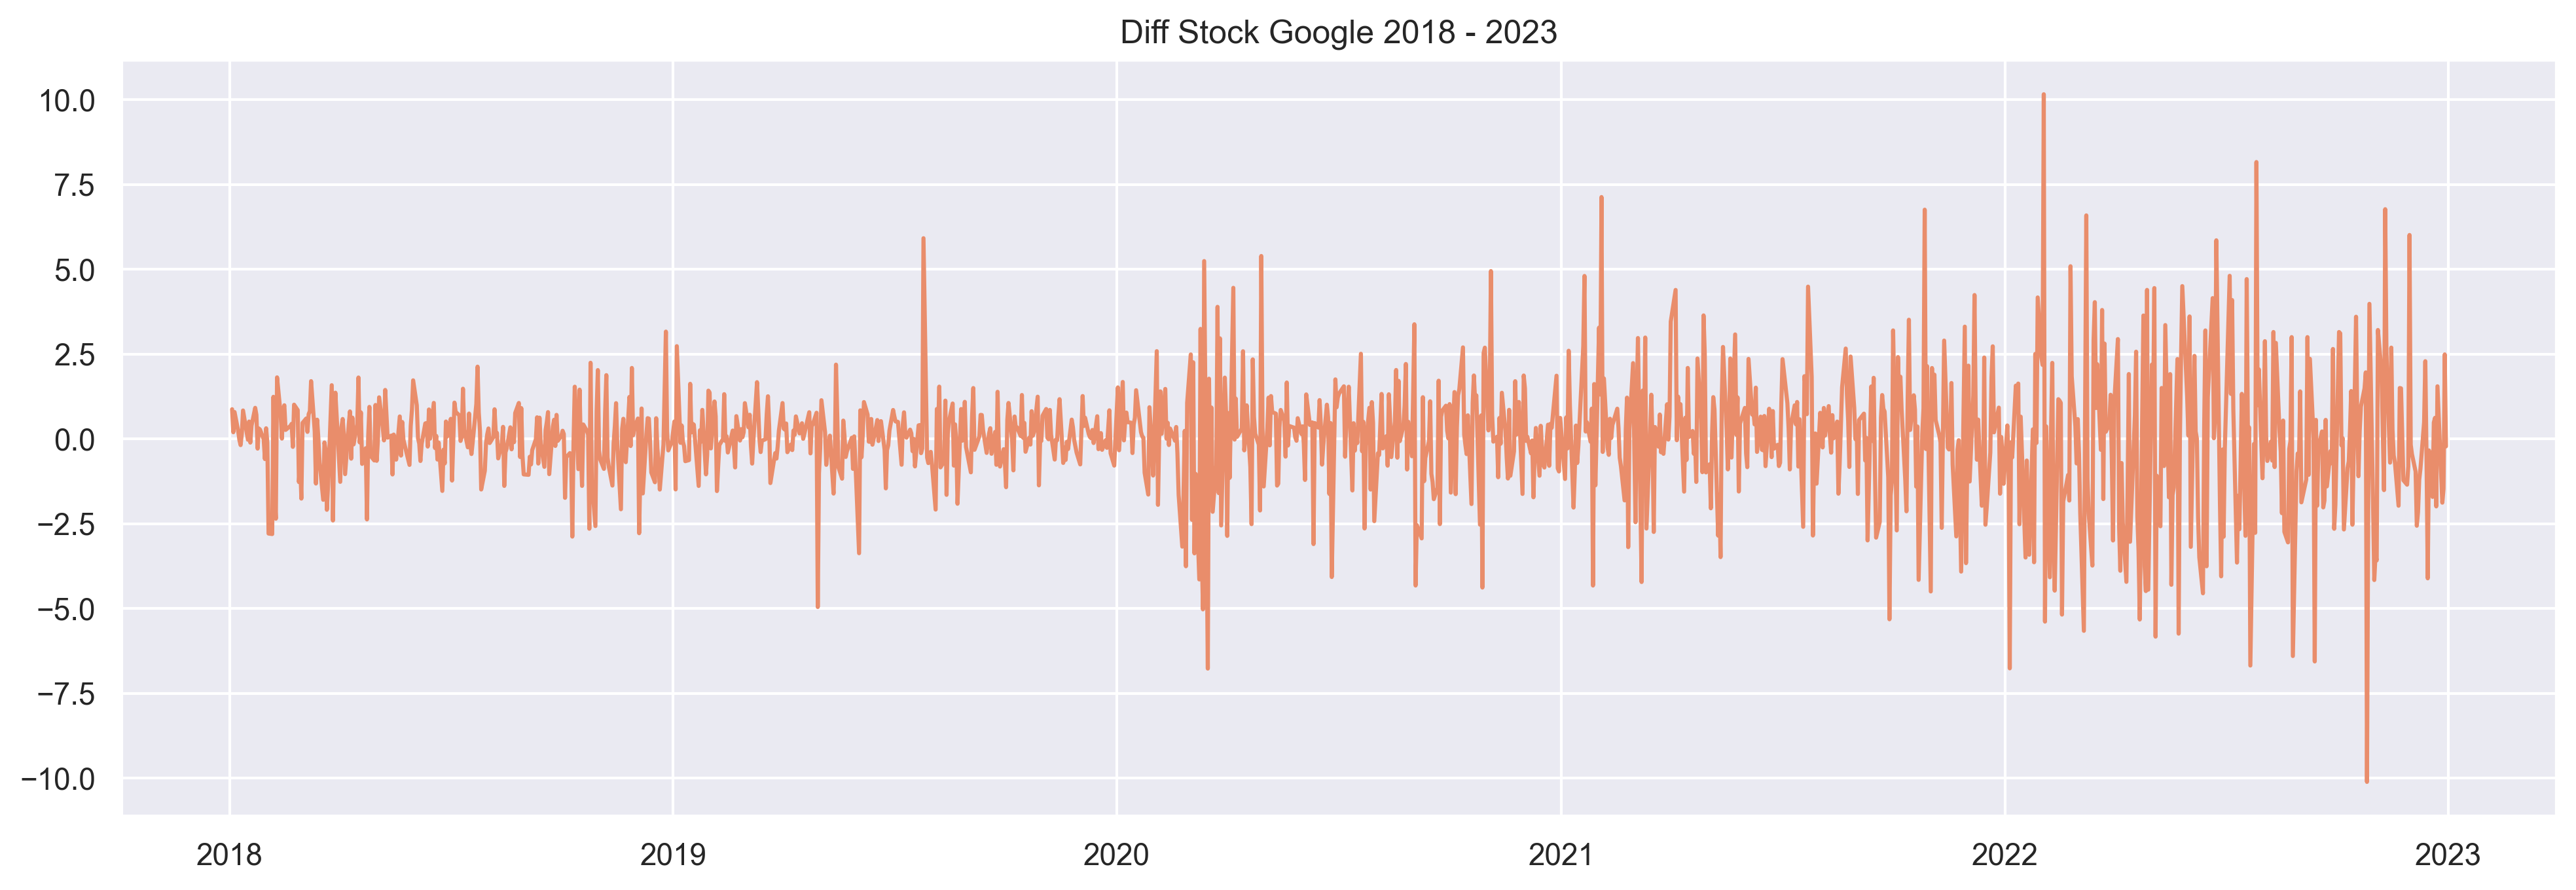

In [326]:
adjust()
plt.plot(dataset.index, dataset['Adj Close'].diff())
plt.title('Diff Stock Google 2018 - 2023')
plt.show()

In [327]:
stat, p, lag, obs, critical, t = sm_api.tsa.stattools.adfuller(dataset)
if p > 0.05:
    print(f'H0 accepted and data probably has unit root with pvalue {p}')
else:
    print(f'H0 rejected and data probably has no unit root with pvalue {p}')
print(f"""
statictical: {stat}
critical value: {critical}""")

H0 accepted and data probably has unit root with pvalue 0.6689176927500179

statictical: -1.2108345267877028
critical value: {'1%': -3.4355629707955395, '5%': -2.863842063387667, '10%': -2.567995644141416}


Stasionary is when the data has no unit root.

So the data has a unit root. That means the data is a non-stationary. Now it's possible to see the seasonal decomposition

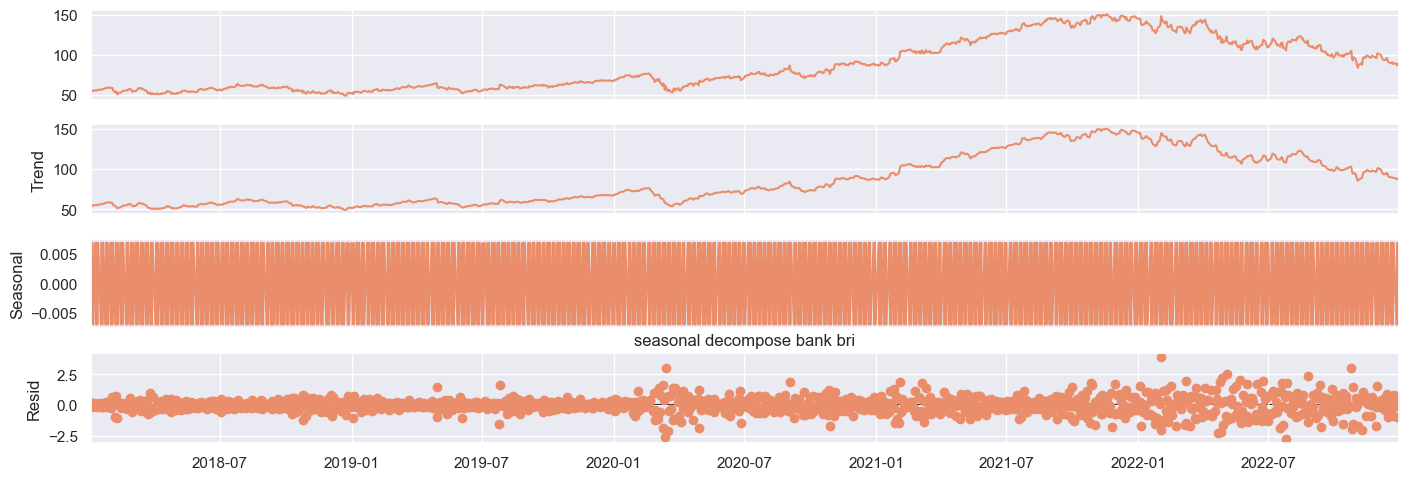

In [328]:
sm.tsa.seasonal.seasonal_decompose(dataset, model='additive', period=2).plot().set_size_inches(w=16, h=5)
plt.title('seasonal decompose bank bri')
plt.show()

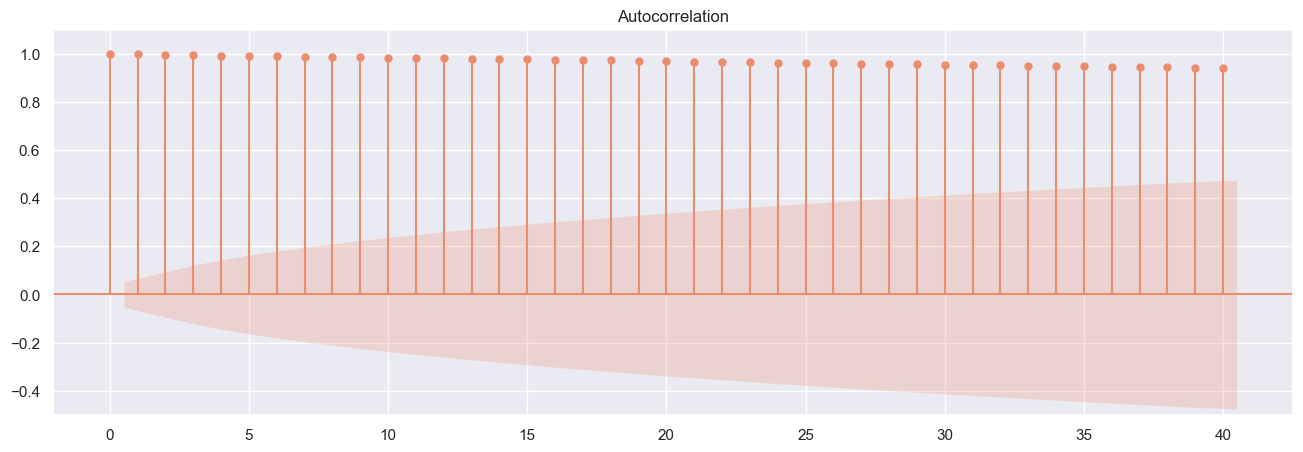

In [329]:
sm_api.graphics.tsa.plot_acf(dataset, lags=40).set_size_inches(w=16, h=5)
plt.ylim(-0.5, 1.1)
plt.show()

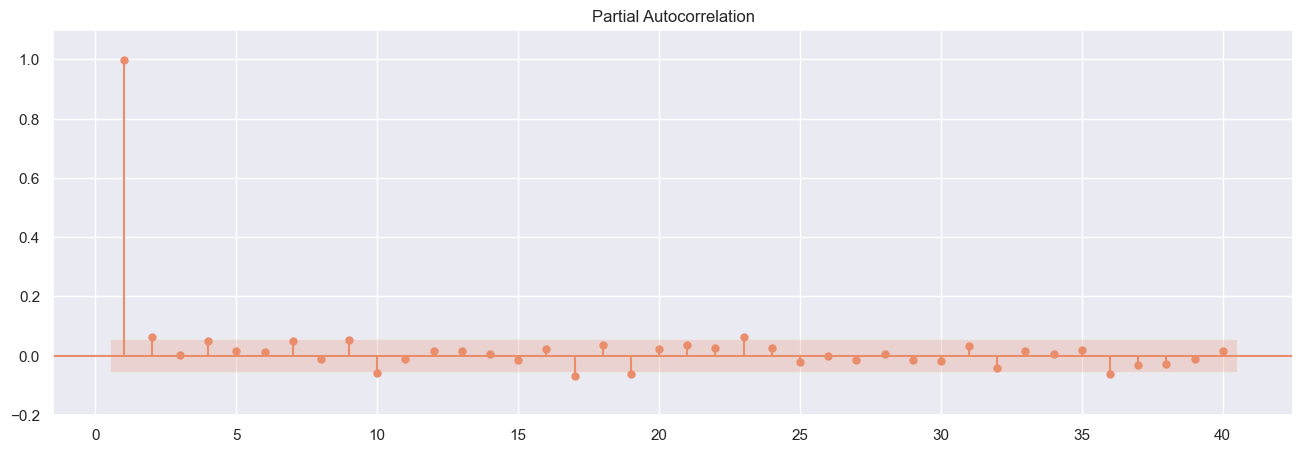

In [330]:
sm_api.graphics.tsa.plot_pacf(dataset, lags=40, alpha=0.05, zero=False, method=('ols')).set_size_inches(w=16, h=5)
plt.ylim(-0.2, 1.1)
plt.show()

# train the model

In [331]:
shift_1 = dataset.shift(1)
shift_2 = dataset.shift(2)
shift_3 = dataset.shift(3)
shift_4 = dataset.shift(4)
shift_5 = dataset.shift(5)

In [332]:
shift = pd.concat((shift_5, shift_4, shift_3, shift_2, shift_1), axis=1)
shift.columns = ['shift_5', 'shift_4', 'shift_3', 'shift_2', 'shift_1']

In [333]:
shift.head()

,shift_5,shift_4,shift_3,shift_2,shift_1
Date,,,,,
2018-01-02,NaN,NaN,NaN,NaN,NaN
2018-01-03,NaN,NaN,NaN,NaN,53.250000
2018-01-04,NaN,NaN,NaN,53.250000,54.124001
2018-01-05,NaN,NaN,53.250000,54.124001,54.320000
2018-01-08,NaN,53.25,54.124001,54.320000,55.111500


In [334]:
shift['y'] = dataset['Adj Close']

In [335]:
shift = shift.dropna()

In [336]:
split = int(len(shift)*0.8)

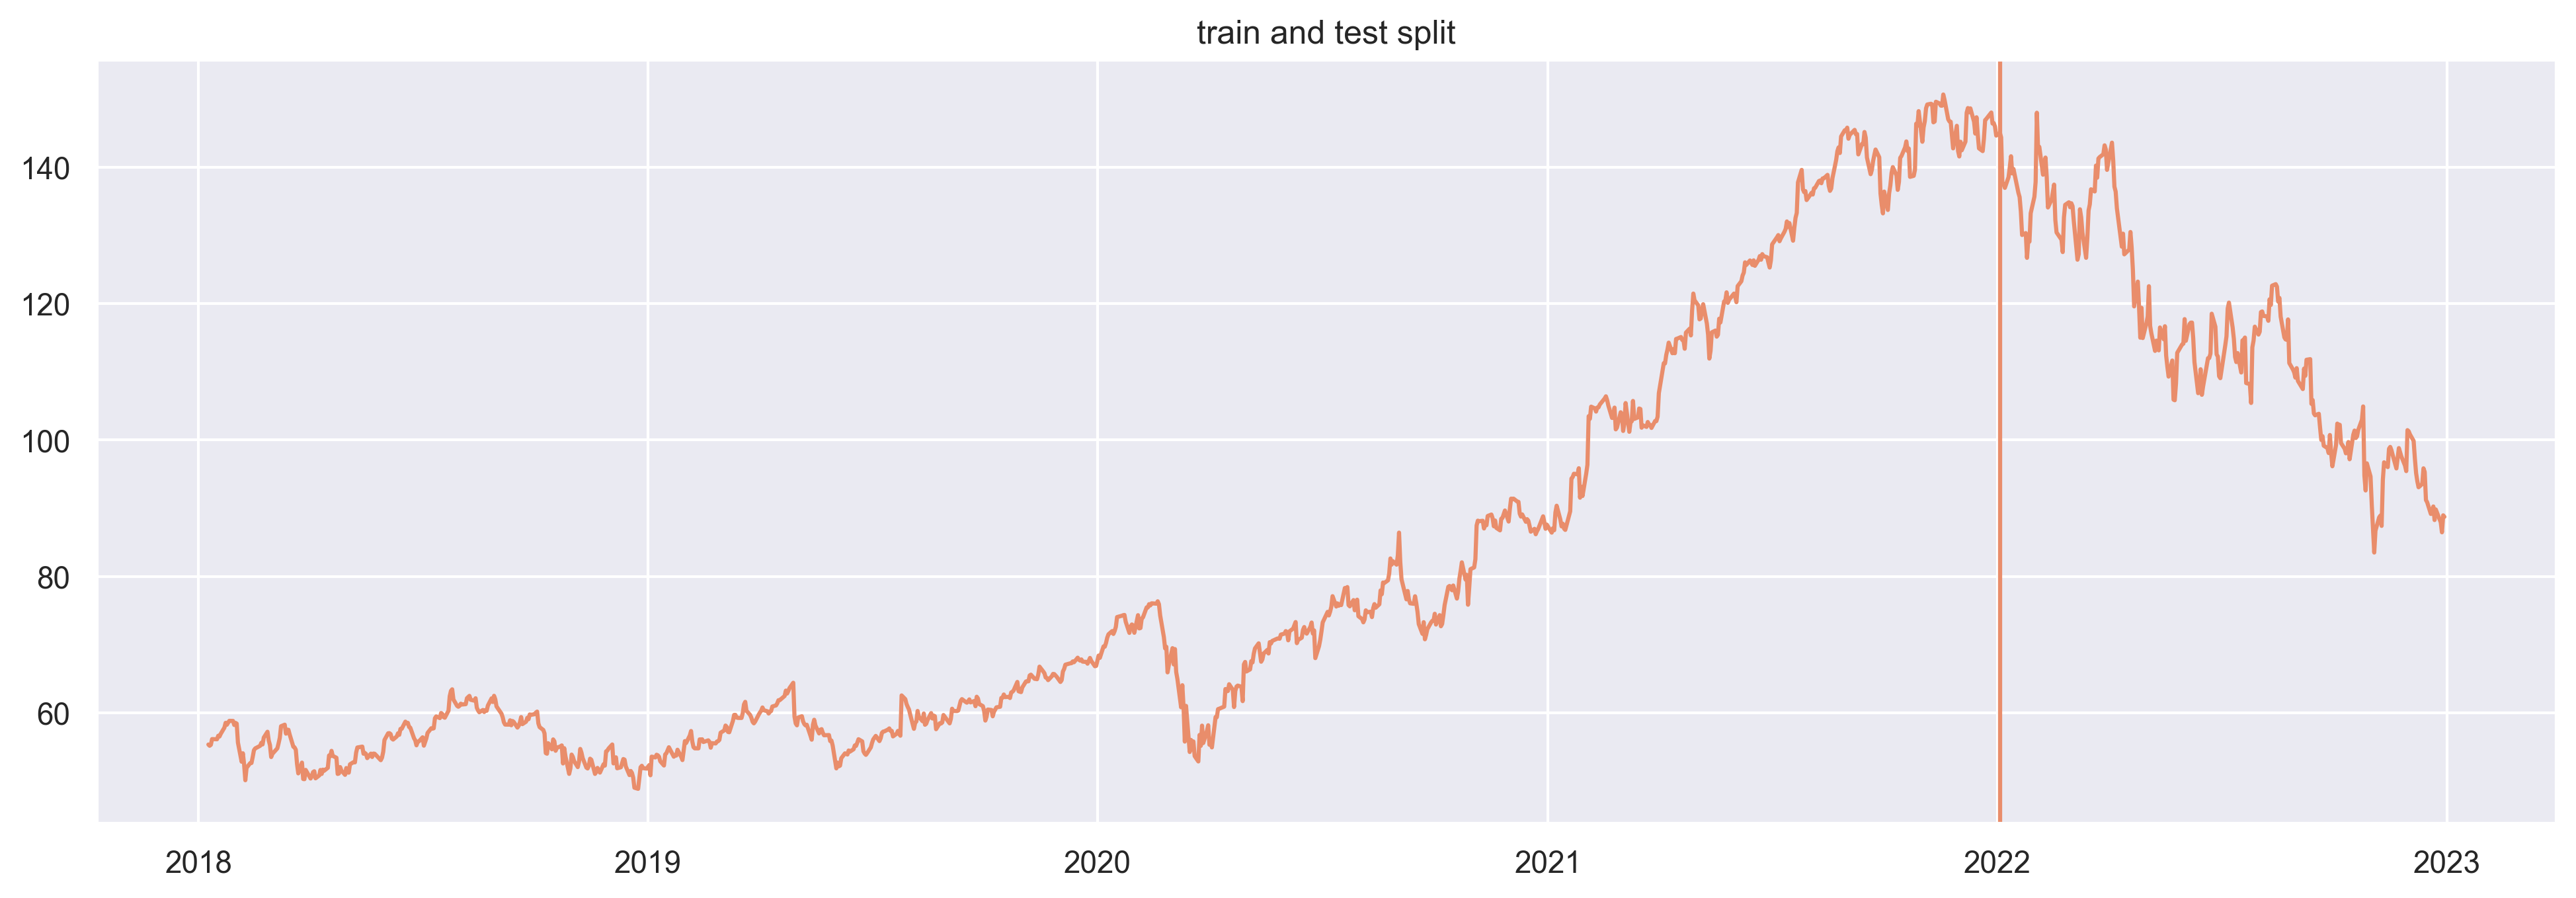

In [337]:
adjust()
plt.plot(shift.y)
plt.axvline(shift.index[split])
plt.title('train and test split')
plt.show()

In [338]:
train, test = shift[:split], shift[split:]
x_train, y_train = train.drop(['y'], axis=1).values, train['y'].values
x_test, y_test = test.drop(['y'], axis=1).values, test['y'].values

In [339]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(1003, 5)
(1003,)
(251, 5)
(251,)


In [340]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(x_train, y_train)
pred = model.predict(x_test)

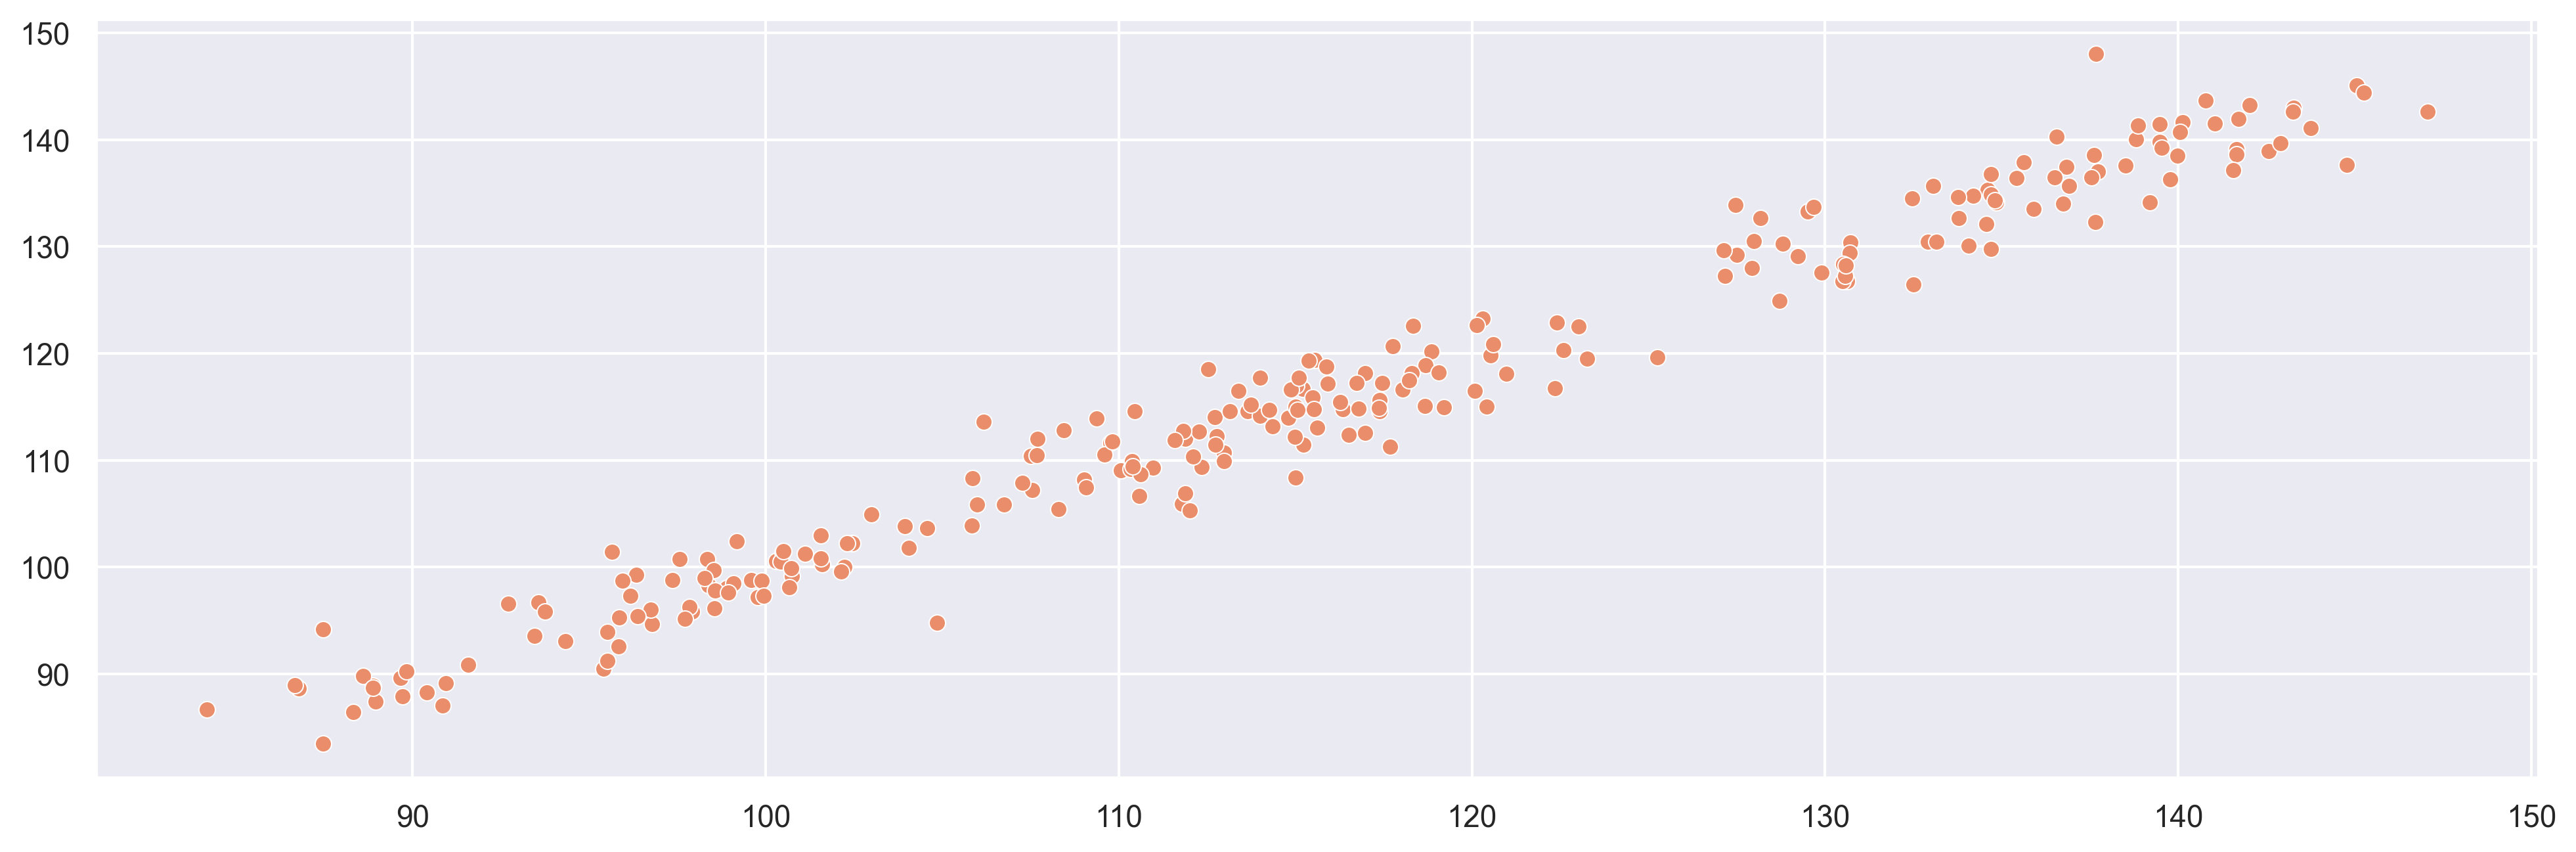

In [341]:
adjust()
sns.scatterplot(x=pred, y=y_test)
plt.show()

In [342]:
forecast = pd.DataFrame(data=pred, index=test.index, columns=['pred'])

In [343]:
forecast.head(10)

,pred
Date,
2022-01-03,145.052953
2022-01-04,145.260307
2022-01-05,144.773700
2022-01-06,138.507148
2022-01-07,137.724287
2022-01-10,137.617722
2022-01-11,138.812024
2022-01-12,140.126716
2022-01-13,141.644876


In [344]:
(test['y'] - forecast['pred']).mean()

-0.4239215188323065

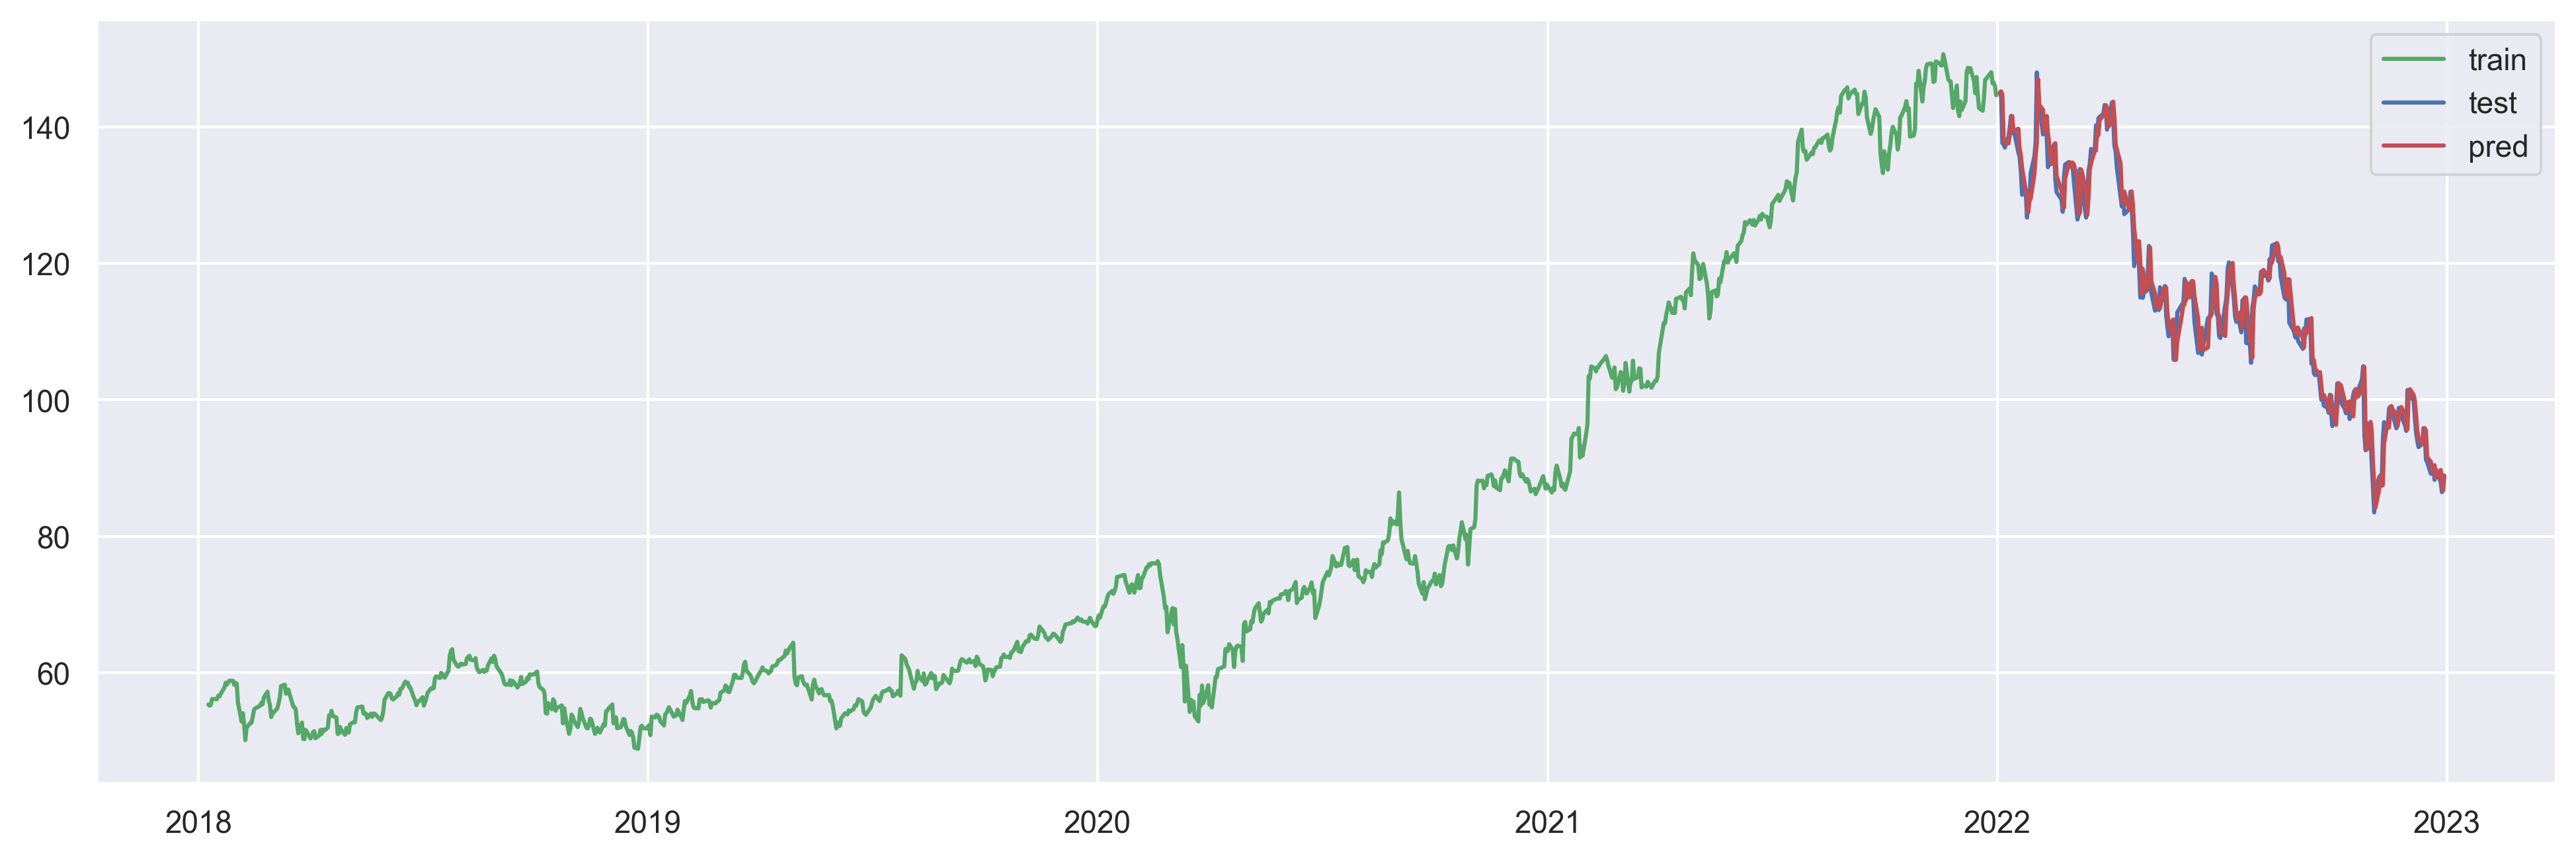

In [345]:
adjust()
plt.plot(train['y'], c='g', label='train')
plt.plot(test['y'], c='b', label='test')
plt.plot(forecast['pred'], c='r', label='pred')
plt.legend()
plt.show()

In [346]:
print(len(train))
print(len(test))

1003
251


In [347]:
train['y'].tail()

Date
2021-12-27    148.063995
2021-12-28    146.447998
2021-12-29    146.504501
2021-12-30    146.002502
2021-12-31    144.679504
Name: y, dtype: float64

In [373]:
var = np.array((train['y'][-5], train['y'][-4], train['y'][-3], train['y'][-2], train['y'][-1]))
var

array([148.06399536, 146.44799805, 146.50450134, 146.00250244,
       144.67950439])

In [376]:
print(test['y'].iloc[0])
print(model.predict([var]))

145.07449340820312
[145.0529525]


In [382]:
variable = np.delete(np.append(var, model.predict([var])), obj=0, axis=0)


array([146.44799805, 146.50450134, 146.00250244, 144.67950439,
       145.0529525 ])

In [383]:
var

array([148.06399536, 146.44799805, 146.50450134, 146.00250244,
       144.67950439])